In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pandas as pd
from matplotlib.ticker import MultipleLocator

In [57]:
def super_gaussian_2d(x, y, w=40.0, n=8):
    """Rotationally symmetric super-Gaussian intensity profile.
    I(r) = exp[-(r/w)^n] normalized so peak = 1.
    w: characteristic radius [µm], n: order (n=2 => Gaussian)
    general gaussian: A*exp[-(x^2)/(2 sigma^2)]
    => for radial symmetry replace x^2 with r^2 = x^2 + y^2
    => generalize exponent with power n instead ^2
    => for higher n sigma is no longer the std => width paramter w"""
    r = np.sqrt(x**2 + y**2)
    I = np.exp(-(r / w)**n)
    return I / I.max()


# grid for plotting
extent = 100        # half-range (µm)
step_size = 0.5     # grid spacing (µm)
xs = np.arange(-extent, extent, step_size)
ys = np.arange(-extent, extent, step_size)
w=44
X, Y = np.meshgrid(xs, ys, sparse=False) # spares saves memmry by removing duplicates, which can by indexed automatically
# returns 2 Arrys [[-80.  -79.5 -79.  -78.5 -78.
#                   -74.  -73.5 -73.  -72.5 -72.]]
#                 [[-79.5]
#                  [-79. ]
#                  [-78.5]]]
# as visible each array only hase 1 column/row, because the shape is symmetric
print(X.shape,Y.shape)

n_values = [2, 5, 6, 7]
peak_shapes = {
    f'Gaussian (n={n})': super_gaussian_2d(X, Y, w, n=n)   # key=i, value=function result
    for n in n_values
}

(400, 400) (400, 400)


### plot the peak shapes

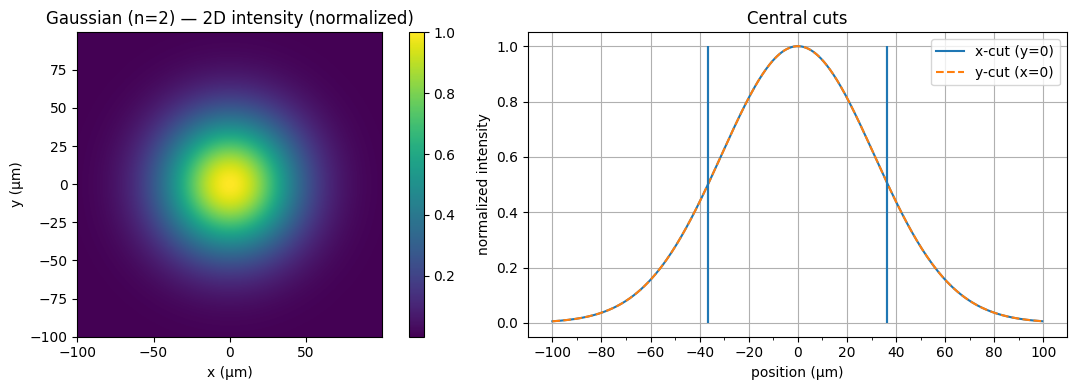

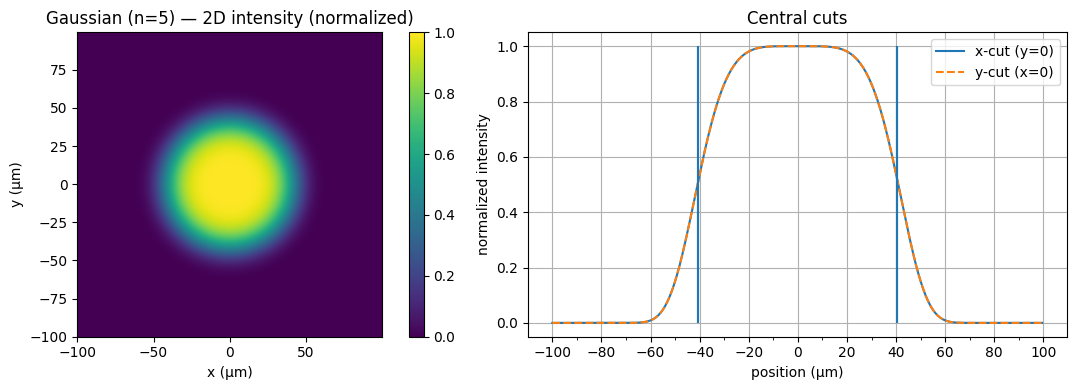

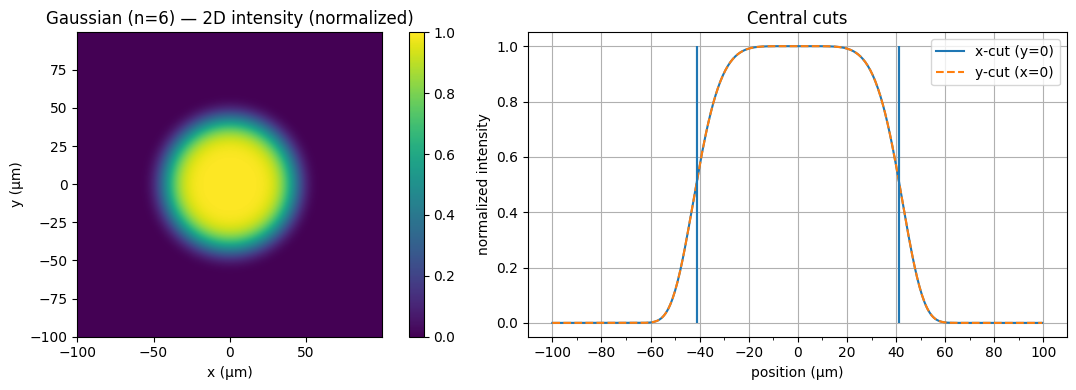

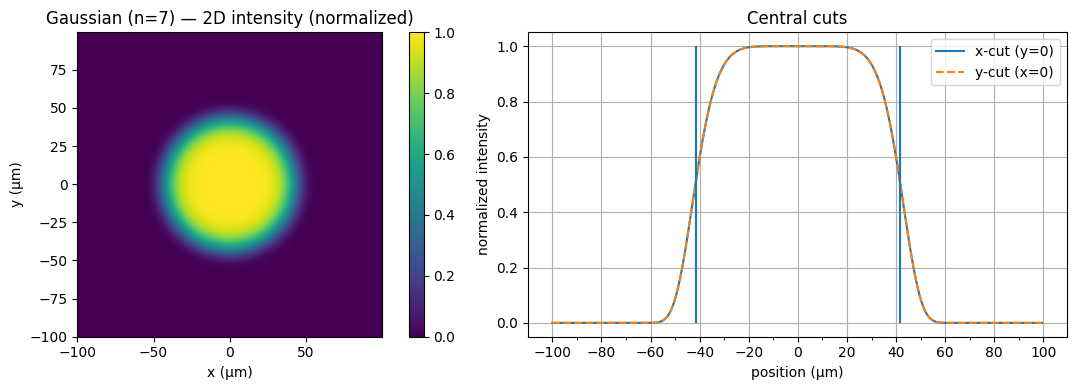

In [58]:
def get_FWHM_super_gaussion(peak, xs, ys):
    # FWHM = 2w(ln2)^(1/n) for gaussians
    half_max = peak.max() / 2

    # Slice through center row for x-direction
    center_y = peak.shape[0] // 2
    profile_x = peak[center_y, :]
    indices_x = np.where(profile_x >= half_max)[0]  # gets indices of all values larger half_max
    fwhm_x = xs[indices_x[-1]] - xs[indices_x[0]]   # get the actual width of those indices in µm and not indices

    # Slice through center column for y-direction
    center_x = peak.shape[1] // 2
    profile_y = peak[:, center_x]
    indices_y = np.where(profile_y >= half_max)[0]
    fwhm_y = ys[indices_y[-1]] - ys[indices_y[0]]
    
    fwhm_x_coords = xs[indices_x[0]], xs[indices_x[-1]]  # left & right edges
    fwhm_y_coords = ys[indices_y[0]], ys[indices_y[-1]]  # bottom & top edges

    return fwhm_x, fwhm_y, fwhm_x_coords, fwhm_y_coords
    
    
# Plot 2D maps and central cuts for each beam type
for name, peak in peak_shapes.items():
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(1,2,1)
    im = ax1.imshow(peak, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]]) # indexes all elements of the meshgrid and creates an array the size of the plot + lower sets (0,0) bottom-left
    ax1.set_title(f"{name} — 2D intensity (normalized)")
    ax1.set_xlabel("x (µm)")
    ax1.set_ylabel("y (µm)")
    # plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    plt.colorbar(im, ax=ax1, fraction=0.05, pad=0.05)
    
    # plot 1D peak profile
    ax2 = fig.add_subplot(1,2,2)
    center_idx = len(xs)//2
    ax2.plot(xs, peak[center_idx,:], label="x-cut (y=0)")
    ax2.plot(ys, peak[:,center_idx], linestyle='--', label="y-cut (x=0)")

    fwhm_x, fwhm_y, fwhm_x_coords, fwhm_y_coords = get_FWHM_super_gaussion(peak, xs, ys)
    ax2.vlines([fwhm_x_coords, fwhm_y_coords], 0,1)

    # ax2.set_xticks()
    ax2.xaxis.set_major_locator(MultipleLocator(20))
    ax2.xaxis.set_minor_locator(MultipleLocator(10))
    
    ax2.set_title("Central cuts")
    ax2.set_xlabel("position (µm)")
    ax2.set_ylabel("normalized intensity")
    ax2.grid()
    ax2.legend()
    plt.tight_layout()
    plt.show()

n = 7 gives the closest result to the data of Carsten Hellinger
=> is used in the following overlapping simulation

### Overlap simulation

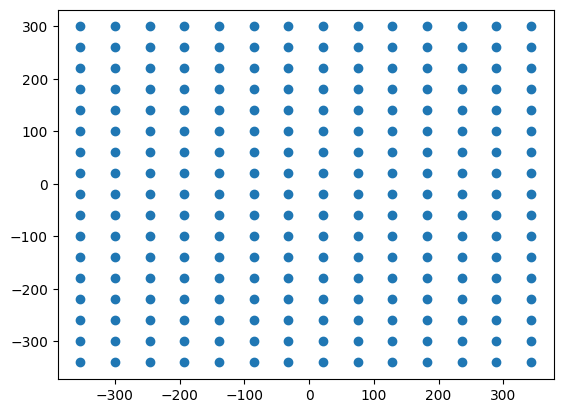

In [59]:
# create new beam profile
# -> for better reafability only 
# using the same parameters as the previous plots
w = 44
n = 7

grid_size = 300    # half-range (µm) + and -
grid_res = 1.0     # resolution in µm

pattern = 'rect'
spacing_x = 80*0.67     # shift between spots in µm  67 %
spacing_y = 80*0.5     # shift between spots in µm  50 %

# create grid in µm dimensions in which the overlapping is simulated
xs = np.arange(-grid_size, grid_size, grid_res)
ys = np.arange(-grid_size, grid_size, grid_res)
X, Y = np.meshgrid(xs, ys)

# create an array of the centers of spots to be overlappt
# => creates map of the peak coordinates
def get_positions_grid(spacing_x, spacing_y, pattern="rect", bounds=grid_size):
    centers = []
    if pattern == "rect":
        xs_grid = np.arange(-bounds - spacing_x, bounds + spacing_x, spacing_x)
        ys_grid = np.arange(-bounds - spacing_y, bounds + spacing_y, spacing_y)
        for xi in xs_grid:
            for yi in ys_grid:
                centers.append((xi, yi))
                
    elif pattern == "hex":
        dx = spacing_x
        dy = spacing_x * np.sqrt(3)/2
        ys_grid = np.arange(-bounds - dy, bounds + dy, dy)
        xs_grid = np.arange(-bounds - dx, bounds + dx, dx)
        for j, yi in enumerate(ys_grid):
            xshift = 0.5*dx if (j % 2)==0 else 0.0
            for xi in xs_grid:
                centers.append((xi + xshift, yi))
                
    return np.array(centers)

position_grid = get_positions_grid(spacing_x, spacing_y, pattern=pattern, bounds=grid_size)

fig, ax = plt.subplots()
ax.scatter(position_grid[:,0], position_grid[:,1])
plt.show()

now that the locations of the spots are defined, the actual peak shap can be overlapped by summing up all intensity values for each location

In [60]:
def overlapped_intensity(centers, beam_func):
    I = np.zeros_like(X)
    for cx, cy in centers:
        # print(cx, cy)
        I += beam_func(X - cx, Y - cy)  # to shift the peak to be at the desired position
    return I

beam_func = super_gaussian_2d(X, Y, w, n=n)
I = overlapped_intensity(position_grid, super_gaussian_2d)


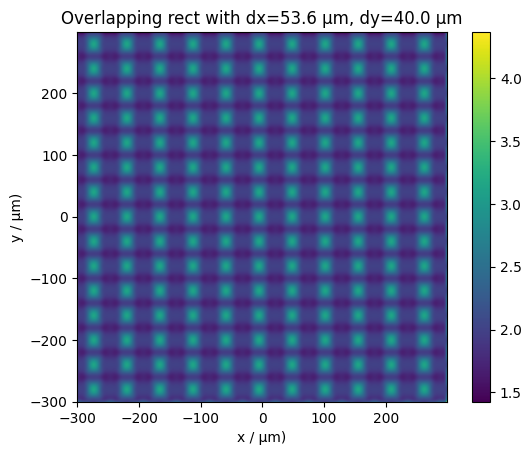

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(I, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]])
ax.set_xlabel("x / µm")
ax.set_ylabel("y / µm")
title = ax.set_title(f'Overlapping {pattern} with dx={spacing_x} µm, dy={spacing_y} µm')
fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05)
plt.savefig(f'Output/{title.get_text()}.png')
plt.show()

### only look at a central window for analysis to avoid border effects

In [62]:
# evaluation mask (central area)
eval_half = 50
eval_mask = (np.abs(X) <= eval_half) & (np.abs(Y) <= eval_half)

mid_x = X.shape[1] // 2
mid_y = X.shape[0] // 2

# Slice around the center
Xc = X[mid_y - eval_half: mid_y + eval_half, mid_x - eval_half: mid_x + eval_half]
Yc = Y[mid_y - eval_half: mid_y + eval_half, mid_x - eval_half: mid_x + eval_half]
Ic = I[mid_y - eval_half: mid_y + eval_half, mid_x - eval_half: mid_x + eval_half]

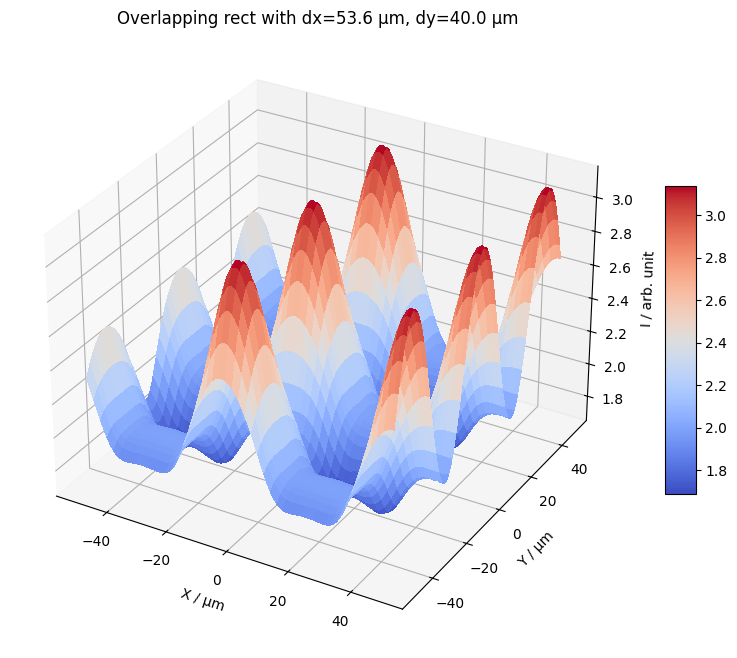

In [63]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
surf = ax.plot_surface(Xc,Yc, Ic, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set(xlabel='X / µm', ylabel='Y / µm', zlabel='I / arb. unit')  # xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100)
title = ax.set_title(f'Overlapping {pattern} with dx={spacing_x} µm, dy={spacing_y} µm')
plt.savefig(f'Output/{title.get_text()}_3D.png')
plt.show()

## compare multiple different spacings

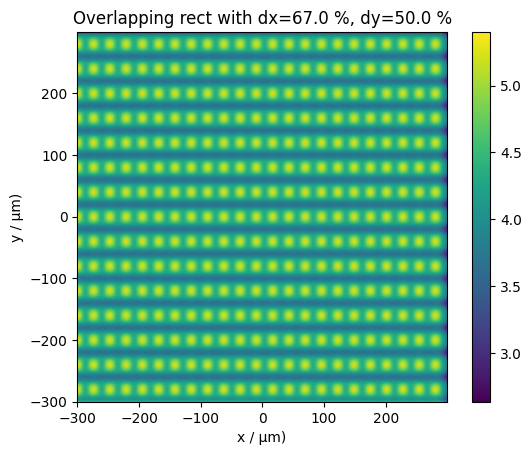

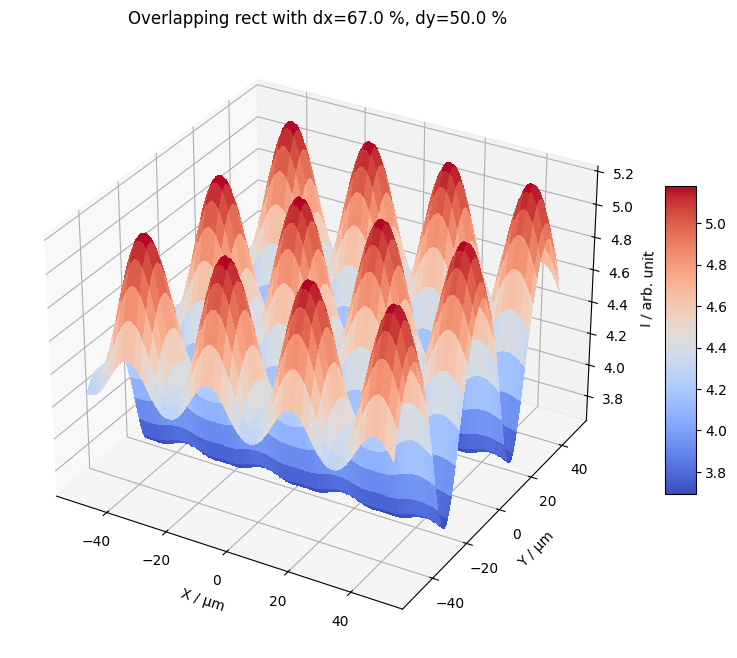

0 0.67 0.5


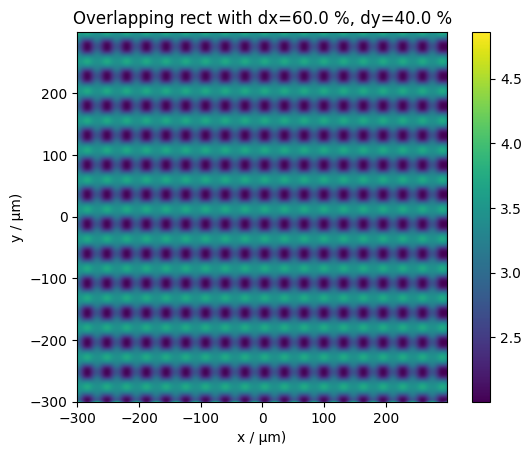

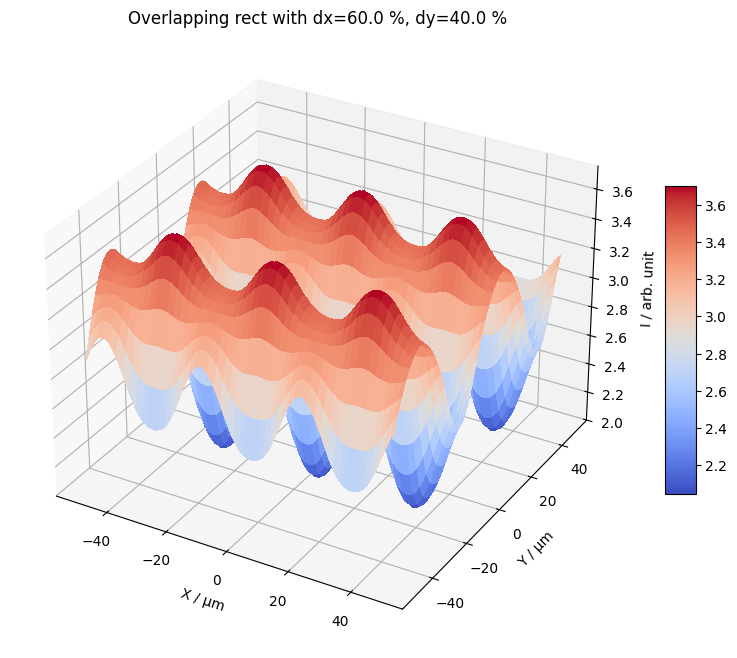

1 0.6 0.4


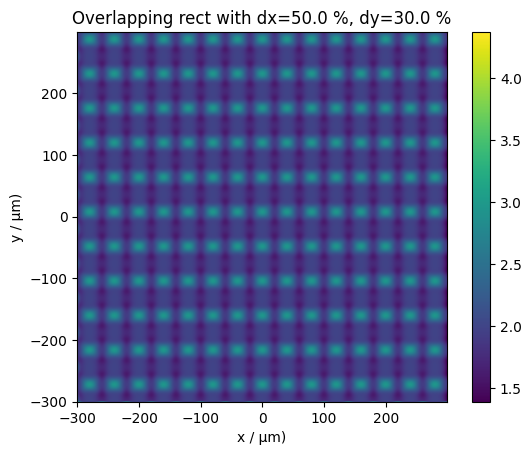

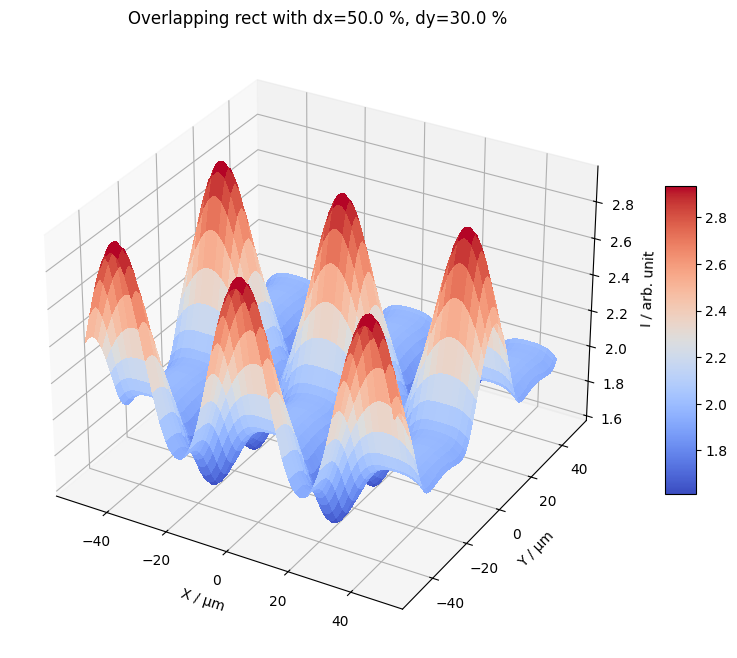

2 0.5 0.3


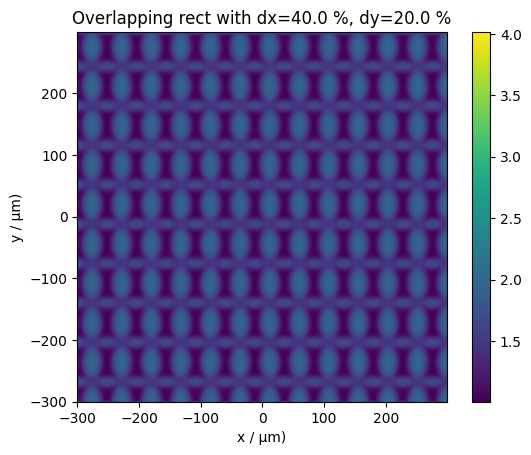

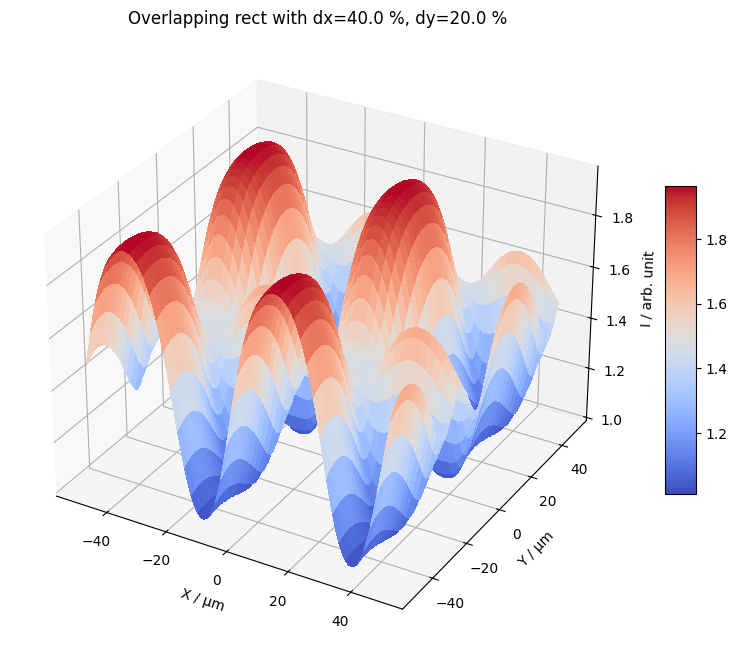

3 0.4 0.2


In [ ]:
# create new beam profile
# -> for better reafability only 
# using the same parameters as the previous plots
w = 44
n = 7

grid_size = 300    # half-range (µm) + and -
grid_res = 1.0     # resolution in µm

# create grid in µm dimensions in which the overlapping is simulated
xs = np.arange(-grid_size, grid_size, grid_res)
ys = np.arange(-grid_size, grid_size, grid_res)
X, Y = np.meshgrid(xs, ys)

pattern = 'rect'

overlapp_x = np.array([0.67, 0.60, 0.50, 0.40])
overlapp_y = np.array([0.50, 0.40, 0.30, 0.20])
spacing_x = 80-(80*overlapp_x)
spacing_y = 80-(80*overlapp_y)

# spacing_x = [80*0.67, 80*0.60, 80*0.50, 80*0.40]    # shift between spots in µm,  67 % standard at iisb
# spacing_y = [80*0.50, 80*0.40, 80*0.30, 80*0.20]    # shift between spots in µm,  50 %standard at iisb

for i, spacing in enumerate(spacing_x):
    # get peak positions
    position_grid = get_positions_grid(spacing_x[i], spacing_y[i], pattern=pattern, bounds=grid_size)

    # overlapp peaks
    beam_func = super_gaussian_2d(X, Y, w, n=n)
    I = overlapped_intensity(position_grid, super_gaussian_2d)
    
    # evaluation mask (central area)
    eval_half = 50
    eval_mask = (np.abs(X) <= eval_half) & (np.abs(Y) <= eval_half)

    mid_x = X.shape[1] // 2
    mid_y = X.shape[0] // 2

    # Slice around the center
    Xc = X[mid_y - eval_half: mid_y + eval_half, mid_x - eval_half: mid_x + eval_half]
    Yc = Y[mid_y - eval_half: mid_y + eval_half, mid_x - eval_half: mid_x + eval_half]
    Ic = I[mid_y - eval_half: mid_y + eval_half, mid_x - eval_half: mid_x + eval_half]
    
    
    # 2D plot
    fig, ax = plt.subplots()
    im = ax.imshow(I, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]])
    ax.set_xlabel("x / µm")
    ax.set_ylabel("y / µm")
    title = ax.set_title(f'Overlapping {pattern} with dx={overlapp_x[i]*100} %, dy={overlapp_y[i]*100} %')
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05)
    plt.savefig(f'Output/{title.get_text()}.png')
    plt.show()
        
    # 3D plot
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
    surf = ax.plot_surface(Xc,Yc, Ic, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set(xlabel='X / µm', ylabel='Y / µm', zlabel='I / arb. unit')  # xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100)
    title = ax.set_title(f'Overlapping {pattern} with dx={overlapp_x[i]*100} %, dy={overlapp_y[i]*100} %')
    plt.savefig(f'Output/{title.get_text()}_3D.png')
    plt.show()
    
    print(i, overlapp_x[i], overlapp_y[i])

In [ ]:
results = []
for pat in patterns:
    for s in spacings:
        centers = generate_grid_centers(s, pattern=pat, bounds=extent)
        Icomp = composite_intensity(centers, lambda x,y: super_gaussian_2d(x,y,w=w,n=6), X, Y)
        # Compute homogeneity metric in a central region to avoid edge effects:
        central_mask = (np.abs(X) <= 60) & (np.abs(Y) <= 60)  # central 120x120 µm region
        vals = Icomp[central_mask]
        mean = vals.mean()
        std = vals.std()
        cov = std/mean if mean>0 else np.nan
        results.append({"pattern": pat, "spacing": s, "mean": mean, "std": std, "cov": cov, "Icomp": Icomp})

In [7]:
df = pd.DataFrame([{"pattern": r["pattern"], "spacing": r["spacing"], "mean": r["mean"], "std": r["std"], "cov": r["cov"]} for r in results])
df

,pattern,spacing,mean,std,cov
0,square,30,0.851001,0.022597,0.026554
1,square,40,0.669346,0.013789,0.020601
2,square,50,0.506634,0.083130,0.164084
3,square,60,0.394000,0.063108,0.160173
4,hex,30,0.970461,0.011628,0.011982
5,hex,40,0.731491,0.037613,0.051419
6,hex,50,0.693446,0.063383,0.091403
7,hex,60,0.440406,0.097502,0.221392


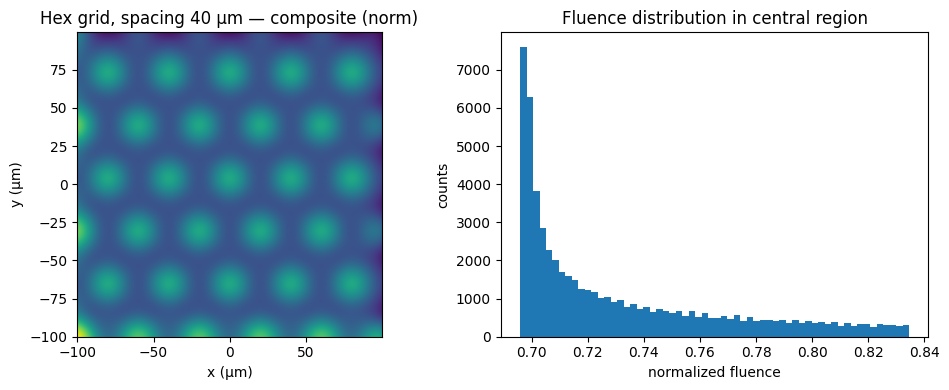

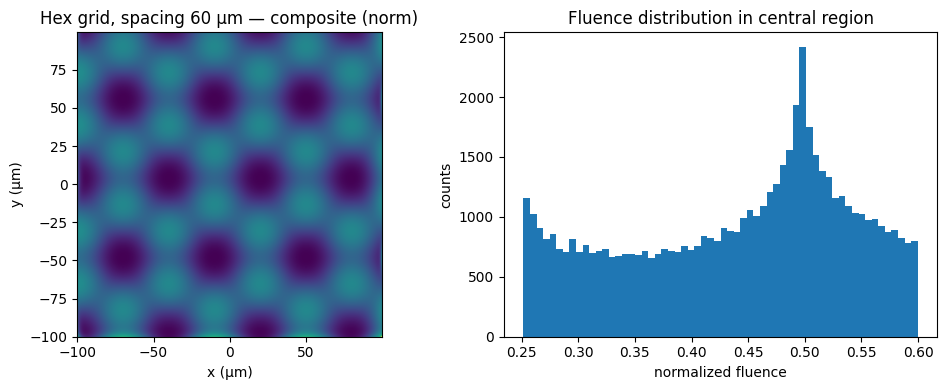


Numeric summary (lower CoV => better uniformity):

pattern  spacing     mean      std      cov
    hex       30 0.970461 0.011628 0.011982
 square       40 0.669346 0.013789 0.020601
 square       30 0.851001 0.022597 0.026554
    hex       40 0.731491 0.037613 0.051419
    hex       50 0.693446 0.063383 0.091403
 square       60 0.394000 0.063108 0.160173
 square       50 0.506634 0.083130 0.164084
    hex       60 0.440406 0.097502 0.221392


In [8]:
# Show composite maps for representative cases and histograms
for r in results:
    if r["spacing"] in (40, 60) and r["pattern"] == "hex":
        Icomp = r["Icomp"]
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].imshow(Icomp, origin='lower', extent=[xs[0], xs[-1], ys[0], ys[-1]])
        ax[0].set_title(f"{r['pattern'].capitalize()} grid, spacing {r['spacing']} µm — composite (norm)")
        ax[0].set_xlabel("x (µm)"); ax[0].set_ylabel("y (µm)")
        ax[1].hist(Icomp[(np.abs(X)<=60)&(np.abs(Y)<=60)].ravel(), bins=60)
        ax[1].set_title("Fluence distribution in central region")
        ax[1].set_xlabel("normalized fluence"); ax[1].set_ylabel("counts")
        plt.tight_layout()
        plt.show()

# Print numeric summary sorted by cov (lower = more uniform)
print("\nNumeric summary (lower CoV => better uniformity):\n")
print(df.sort_values("cov").to_string(index=False))